# Example for Testing
Don't expect this note to be stable, this is for my testing purposes (Caglar).

In [1]:
%load_ext autoreload
%autoreload 1
import sys, os
# We need to insert the root path of the project by hand.
sys.path.insert(0, os.path.abspath('..')) # find a way so that not every notebook needs to call this
%aimport chapp
import chapp

0.018962
3793 3793 1897
Mean [dBm]: -153.80320620703773
(Mean/Stdev)^2: 1.0553235335302753
Slope: 55.654653176367226


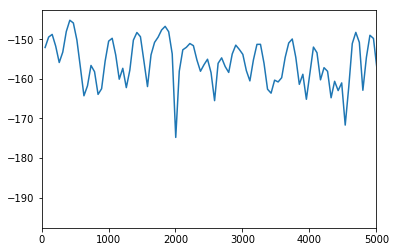

In [121]:
from chapp.sim.spectrumanalyzer import FSVSpectrumMaker
from chapp.sim.signal import make_sine, make_ideal_thermal_noise
from chapp.sim.windowing import windows_heinzel as windows
from chapp.sim.windowing import WindowFunction
import numpy as np
import attr

# Real boxcar has non-1 3dBbw which leads to an unexpected swt calculation.
# While it may be correct, it confuses me currently so to hell with it.
fakeboxcar = WindowFunction.from_dict(attr.asdict(windows.Rectangular))
fakeboxcar.n3dbbw = 1 # to fix swt in the case of boxcar

import matplotlib.pyplot as plt

noise = make_ideal_thermal_noise(temperature=290, resistance=50)
sm = FSVSpectrumMaker.from_dict()
sm.is_auto_swt = True
sm.window = windows.BH92
sm.window.rov = 0.5
sm.rbw = 100
sm.span = 1e5
sm.swt = sm.swt*1

sm.scaling='spectrum'
sm.input = noise

print(sm.swt)
sm.padcoeff = 1
print(sm.nperseg, sm.nsamples, sm.noverlap)
#print(sm.window)
sm.generate()

noise_correction = sm.window.n3dbbw/sm.window.nenbw


plt.plot(sm.frequency, 10*np.log10(sm.spectrum)+30) # dBm
plt.xlim((0,5e3))
s = sm.spectrum*noise_correction
print(f"Mean [dBm]: {10*np.log10(noise_correction*sm.spectrum.mean())+30}")
print(f"(Mean/Stdev)^2: {(s.mean()/s.std())**2}")
print(f"Slope: {(s.mean()/s.std())**2/sm.swt}")
# Endpoints are probably artifacts of sampling noise improperly (?).


In [111]:
#!/usr/bin/python3
"""Some reiterations of the definitions is due here:
    Measurement: A collection of single measurement of different types.  It is
        crucial that each type of measurement only performed once.  Performing once
        means we can refer to it with a phrase like "spectrum measurement" even
        though spectrum measurement intrinsically employs collection of multiple
        samples given an amount of time.  A measurement comes with a set of
        parameters that is crucial for it's interpretation.
    Run: A collection of repeated Measurements characterized by a set of
        parameters.
    Experiment: A collection of Runs with one or more parameters changed.

"""

import pandas as pd
import numpy as np

# Some cool stuff
import attr
import typing

import sys,glob,os,time,re
from itertools import groupby, islice, repeat, chain
from collections import OrderedDict

class INIKeyError(Exception):
    pass


@attr.s(auto_attribs=True)
class Spectrum:
    @attr.s(auto_attribs=True)
    class Units:
        frequency: str = "Hz"
        power: str = "Watt"
    frequency: np.ndarray
    power: np.ndarray
    units: Units = attr.Factory(Units)

    @classmethod
    def from_arrays(cls, frequency: np.ndarray, power: np.ndarray, 
            units: typing.Optional[typing.Tuple[str, str]]=None):
        if units is None:
            return cls(frequency, power)
        else:
            units = cls.Units(*units)
            return cls(frequency, power, units)


@attr.s(auto_attribs=True)
class MeasurementParams:
    measno: int # Measurement number
    swt: float # Sweep time in seconds
    qswt: float # Sweep time as queried from instrument
    points: int # Sweep points
    elapsed: float # Elapsed time in seconds
    rbw: float # RBW in seconds
    span: float # SPAN in seconds

    @classmethod
    def from_dict(cls, dct: typing.Dict[str, str], converters=None):
        """FIX: Handle unknowns, or explicitly don't handle."""
        attrnames = {attr.name for attr in cls.__attrs_attrs__}
        d = {}
        for attrn in attrnames:
            v = dct[attrn]
            try:
                d[attrn] = converters[attrn](v)
            except (TypeError, KeyError) as e: # if converters is None, this gives type error
                d[attrn] = v
        return cls(**d)

    @classmethod
    def from_INI_lines(cls, lines: typing.Iterable[str],
            name_map: typing.Optional[typing.Dict[str,str]] = None,
            ignore_parse_errors: bool=True, ignore_unknowns: bool=True):
        """From a list of strings containing INI style name=value pairs.
        Argument name_map is a mapping from names in the INI to the names
        required by this class.

        Errors:
            INIKeyError: Raised in case a line doesn't contain proper INI style.
        """
        attrtypes = {attr.name:attr.type for attr in cls.__attrs_attrs__}
        d = {}
        for line in lines:
            try:
                name, value = line.split('=')
                if name_map is not None:
                    name = name_map[name]
            except ValueError as e: # Parse error when assigning tuple
                if not ignore_parse_errors:
                    raise INIKeyError(f"Invalid INI key on line: {line}") from e
            except KeyError as e: 
                if name in attrtypes.keys():
                    pass
                elif ignore_unknowns:
                    continue
                else:
                    raise INIKeyError(f"Unknown INI key on line: {line}") from e
            d.update({name: value})
        converters = attrtypes # using type constructors to read string
        return cls.from_dict(d, converters)


def downsample(array: np.ndarray, r: int): # decimation?
    n = len(array)
    qu,rem = np.divmod(n,r)
    if rem != 0:
        array = np.pad(array, (0, r-rem), mode='constant')
        qu = qu+1
    shape = (qu, r)
    return np.reshape(array, shape).T[0] #picks first


@attr.s(auto_attribs=True)
class Measurement:
    param: MeasurementParams
    spectrum: Spectrum

    def to_stats(self, histbins=10):
        p = self.spectrum.power
        return Stats.from_array(p, histbins=histbins)

    @staticmethod
    def _comments(fdesc, comment='#'):
        """Yields initial comments from the given file descriptor"""
        pos = fdesc.tell() # find out where we are in file
        for line in fdesc:
            offset = len(line.encode('utf-8')) # total length of a line
            pos += offset # now where we are
            if line == '\n': continue
            elif line.startswith(comment): yield line[len(comment):].strip()
            else: 
                pos -= offset # go back cuz that we didn't use.
                break
        fdesc.seek(pos)

    @classmethod
    def from_csv(cls, csv: str,
            param_map: typing.Optional[typing.Dict[str, str]]=None,
            downsampling: int=1):
        """Downsampling picks first out of 4 consecutive samples"""
        with open(csv, mode='r') as fin:
            # BEWARE: from_INI_lines consumes the comments!
            measpars = MeasurementParams.from_INI_lines(cls._comments(fin, '#'),
                    name_map=param_map)
            data = np.genfromtxt(fin, delimiter=',', comments='#',
                    usecols=(0,1), skip_header=True)
            f,p = data[:,0], data[:,1]
            if downsampling > 1:
                # print(f"[WARNING] Downsampling by {downsampling}!")
                f = downsample(f, downsampling)
                p = downsample(p, downsampling)

            s = Spectrum.from_arrays(f, p, ('Hz', 'Watt'))
            return cls(spectrum=s, param=measpars)
    
    @classmethod
    def from_arrays(cls, 
                    f: np.ndarray,
                    p: np.ndarray,
                    param: MeasurementParams,
                    downsampling: int=1):
        if downsampling > 1:
            # print(f"[WARNING] Downsampling by {downsampling}!")
            f = downsample(f, downsampling)
            p = downsample(p, downsampling)

        s = Spectrum.from_arrays(f, p, ('Hz', 'Watt'))
        return cls(spectrum=s, param=param)


@attr.s(auto_attribs=True)
class Histogram:
    hist: np.ndarray
    edges: np.ndarray

    def __len__(self):
        return len(self.hist)

    @classmethod
    def from_array(cls, x: np.ndarray, bins: int=10):
        hist, edges = np.histogram(x, bins)
        return cls(hist, edges)


@attr.s(auto_attribs=True)
class Stats:
    histogram: Histogram
    mean: float
    var: float
    min: float
    max: float

    @property
    def std(self): 
        return np.sqrt(self.var)

    @classmethod
    def from_array(cls, array: np.ndarray, histbins: int=10):
        a = array
        h = Histogram.from_array(a, bins=histbins)
        mean, var, min, max = a.mean(), a.var(), a.min(), a.max()
        return cls(h, mean, var, min, max)


@attr.s(auto_attribs=True)
class RunParams:
    swt: float # Sweep time in seconds
    qswt: float # Sweep time as queried from instrument
    points: int # Sweep points
    rbw: float # RBW in seconds
    span: float # SPAN in seconds

    @classmethod
    def from_measurement(cls, measurement):
        mp = measurement.param
        return cls(mp.swt, mp.qswt, mp.points, mp.rbw, mp.span)


@attr.s(auto_attribs=True)
class Run:
    """Keeping up with PACE nomenclature, a Run is a collection of measurements
    with some common set of parameters."""
    mstats: typing.List[Stats]
    elapseds: typing.List[float] # Elapsed times
    param: RunParams
    meascount: int

    def __len__(self):
        return len(self.mstats)

    @classmethod
    def from_measurements(cls, measurements: typing.Iterable[Measurement],
            histbins: int=10, check_consistency=False):
        _mstats, _elapseds = [], []
        it = iter(measurements)
        try:
            first = next(it)
        except StopIteration:
            raise ValueError("Can't create Run from 0 measurements.")
        param = RunParams.from_measurement(first)
        _mstats.append(first.to_stats())
        _elapseds.append(first.param.elapsed)
        k = 1
        for measurement in it:
            if check_consistency:
                assert param == RunParams.from_measurement(measurement)
            _mstats.append(measurement.to_stats())
            _elapseds.append(measurement.param.elapsed)
            k += 1
        return cls(_mstats, _elapseds, param, k)


@attr.s(auto_attribs=True)
class ExperimentParams:
    span: float
    rbw: float
    points: int
    meascount: int

    @classmethod
    def from_run(cls, run):
        rp = run.param
        return cls(rp.span, rp.rbw, rp.points, run.meascount)


@attr.s(auto_attribs=True)
class Experiment:
    runs: typing.List[Run]
    param: ExperimentParams

    @classmethod
    def from_runs(cls, runs: typing.Iterable[Run], 
            check_consistency: bool=False):
        _runs = []
        it = iter(runs)
        try:
            first = next(it)
        except StopIteration:
            raise ValueError("Can't create Experiment from 0 runs.")
        param = ExperimentParams.from_run(first)
        _runs.append(first)
        for run in it:
            if check_consistency:
                assert param == ExperimentParams.from_run(run)
            _runs.append(run)
        return cls(_runs, param)

    @classmethod
    def from_measurements(cls, measurements: typing.Iterable[Measurement],
            histbins: int=10, check_consistency: bool=False,
            issorted: bool=False):
        """This one sorts the measurements and constructs the runs"""
        sortkey = lambda m: (m.param.swt, m.param.measno)
        if not issorted:
            sortd = sorted(measurements, key=sortkey)
        else:
            sortd = measurements
        grouped = groupby(sortd, key=lambda m: m.param.swt)
        runs = (Run.from_measurements(group, histbins, check_consistency) for
                qswt, group in grouped)
        return cls.from_runs(runs)

    @classmethod
    def from_path(cls, path, histbins: int=10,
            param_map: typing.Optional[typing.Dict[str, str]]=None,
            limit: int=0, downsampling: int=1):
        """Collects all the csvs in the path and constructs measurements from
        them.  Doesn't really try to be efficient.  
        
        Args:
            path: Where to look for files.
            histbins: Bin count of histograms when calculating Run.mstats.
            param_map: Parameters found in files mapped to internal parameter
                names.
            limit: Limits the amount of files read.  Limiting happens after
                sorting by name.  limit=0 is equivalent to no limit.
            
            """
        def sorter(fname):
            m = re.match(r'.+SWT_T(?P<swt>[0-9]+\.{0,1}[0-9]{0,10})_M(?P<mno>[0-9]{1,5})\.csv$', fname)
            swt = float(m.group('swt'))
            mno = int(m.group('mno'))
            return swt, mno
        
        fnames = sorted(glob.glob(os.path.join(path, "*.csv")), key=sorter)
        if limit != 0:
            fnames = islice(fnames, limit)

        def reporter(fnames):
            lasttime = time.time()
            for fname in fnames:
                yield fname
                print(f"Just read {fname} and it took"
                      f" {1e3*(time.time()-lasttime):.3f}"
                       " ms.")
                lasttime = time.time()

        reported = reporter(fnames)
        return cls.from_measurements((Measurement.from_csv(fname, param_map, downsampling) 
                                        for fname
                                        in reported), histbins=histbins, issorted=True)

    @classmethod
    def from_tuple_iterable(cls,
                       tuples: typing.Iterable[typing.Tuple[np.ndarray, np.ndarray, MeasurementParams]],
                       histbins: int=10, limit: int=0, downsampling: int=1):
        """WARNING ASSUMES SORTED!"""
        if limit != 0:
            tuples = islice(tuples, limit)
        return cls.from_measurements(
            (Measurement.from_arrays(f, p, param, downsampling=downsampling) 
                for f, p, param in tuples),
            histbins=histbins, issorted=True)


@attr.s(auto_attribs=True)
class FlatResult:
    swts: np.ndarray
    qswts: np.ndarray
    elapseds: np.ndarray
    means: np.ndarray
    stds: np.ndarray
    nsamples: np.ndarray
    efficiencies: np.ndarray
    rbw: typing.Optional[float] = None

    _description = (
            "swt: Sweep time in seconds.", 
            "qswt: Queried sweep time from the instrument after the sweep time is set.",
            "elapsed: Elapsed time between sending the sweep initiation remote command and the reception of a trace.",
            "mean: Mean power from the acquired spectrum. Linear scale.",
            "std: Standard deviation of the power from the acquired spectrum.  Linear scale",
            "nsamples: Estimated number of samples using mean and std.",
            "efficiencies: Estimated efficiency using nsamples and rbw of the measurement.",
        )

    def to_csv(self, fname):
        length = len(self.swts)
        sep = ','
        columns = 'swt qswt elapsed mean std nsample efficiency'.split()
        stacked = np.stack([self.swts, self.qswts, self.elapseds, self.means, 
            self.stds, self.nsamples, self.efficiencies], axis=1)
        paramline = f"# RBW={self.rbw} Hz"
        description = "\n".join(f"# {line}" for line in self._description)
        header = f'{sep} '.join(columns)
        datarows = "\n".join((f'{sep} '.join(map(str,stacked[i,:])) for i in range(length)))
        everything = "\n".join((description, paramline, header, datarows))
        with open(fname, 'w') as fout:
            fout.write(everything)


@attr.s(auto_attribs=True)
class Result:
    """
    Args:
        nsamples: Estimated number of samples per bin in a measurement.
        swts: Sweep time.
        variances:  Spectrum power variances.
        elapseds: Elapsed times.

    """

    # Measurements
    swts: typing.Iterable[float]
    qswts: typing.Iterable[float]
    elapseds: typing.Iterable[np.ndarray]
    means: typing.Iterable[np.ndarray]
    stds: typing.Iterable[np.ndarray]
    # Estimations
    nsamples: typing.Iterable[np.ndarray]
    efficiencies: typing.Iterable[np.ndarray]
    # Some flat parameters
    rbw: typing.Optional[float] = None

    @property
    def lengths(self):
        # change impl. later
        return [len(e) for e in self.elapseds]

    def flatten(self) -> FlatResult:
        # probably inefficient
        swts_f = [np.repeat(swt,length) for swt,length in zip(self.swts, self.lengths)]
        qswts_f = [np.repeat(qswt,length) for qswt,length in zip(self.qswts, self.lengths)]
        s = swts_f
        q = qswts_f
        e = self.elapseds
        m = self.means
        st = self.stds
        n = self.nsamples
        ef = self.efficiencies
        # ioa: iterable of arrays
        fr = FlatResult(*(np.hstack(ioa) for ioa in (s,q,e,m,st,n,ef)))
        fr.rbw = self.rbw
        return fr

    def _transpose(self, lol: typing.Iterable[typing.Iterable[typing.Any]]):
        """This is a method that transposes an iterable by inserting None's at
        whenever internal sizes don't match.  Note that internal Iterables must be
        sizeable for this to be not super inefficient.  This returns an ordered
        iterable of lists currently."""
        levels = OrderedDict()
        maks = len(lol[0])
        for i,row in enumerate(lol):
            if len(row) > maks:
                maks = len(row)
            for j in range(maks):
                try:
                    levels.setdefault(j, []).append(row[j])
                except IndexError:
                    levels.setdefault(j, []).append(None)
        return levels.values()

    def plot(self, attrname): # attr can be nsamples, efficiences, variances
        attrib = getattr(self, attrname)
        rowcnt = len(attrib)
        fig, ax = plt.subplots()
        y = [np.array(row) for row in self._transpose(attrib)]
        for m in y:
            # Multiple measurements having same x value
            # There is probably better way of doing this.
            ax.plot(self.swts, m, '*')
            ax.set_title(f"{attrname.capitalize()} vs SWT")
        return fig, ax


def analyse(experiment: Experiment) -> Result:
    swts_l,qswts_l,elapseds_l,means_l,stds_l,efficiencies_l,nsamples_l= [], [], [], [], [], [], []
    for run in experiment.runs:
        swt = run.param.swt
        qswt = run.param.qswt
        rbw = run.param.rbw

        calcn = lambda m, s: (m/s)**2 # is this the correct estimator?

        nsamples, means, stds, efficiencies = [], [], [], []
        for elapsed, mstat in zip(run.elapseds, run.mstats):
            mean, std, var = mstat.mean, mstat.std, mstat.var
            nestimate = calcn(mean, std)
            nsamples.append(nestimate)
            means.append(mean)
            stds.append(std)
            efficiencies.append(nestimate/rbw/elapsed)

        swts_l.append(swt)
        qswts_l.append(qswt)
        elapseds_l.append(np.array(run.elapseds))
        means_l.append(np.array(means))
        stds_l.append(np.array(stds))
        nsamples_l.append(np.array(nsamples))
        efficiencies_l.append(np.array(efficiencies))

    return Result(swts_l, qswts_l, elapseds_l, means_l, stds_l, nsamples_l,
            efficiencies_l, rbw=rbw)


def write_csv(fname, column_names, columns):
    with open(fname, 'w+') as fout:
        header = ', '.join(column_names)
        rows = []
        maks = max(map(len, columns))
        for i in range(maks):
            row = []
            for column in columns:
                try:
                    row.append(column[i])
                except IndexError:
                    row.append("None")
            rows.append(f"{', '.join(map(str, row))}\n")
        fout.write(f"{header}\n")
        fout.writelines(rows)


[WARNING]: Downsampling by 4
Simulating swt: 0.18962 s. Measno: 0
Simulating swt: 0.18962 s. Measno: 1
Simulating swt: 0.18962 s. Measno: 2
Simulating swt: 0.18962 s. Measno: 3
Simulating swt: 0.18962 s. Measno: 4
Simulating swt: 0.18962 s. Measno: 5
Simulating swt: 0.18962 s. Measno: 6
Simulating swt: 0.18962 s. Measno: 7
Simulating swt: 0.18962 s. Measno: 8
Simulating swt: 0.18962 s. Measno: 9
Simulating swt: 0.199101 s. Measno: 0
Simulating swt: 0.199101 s. Measno: 1
Simulating swt: 0.199101 s. Measno: 2
Simulating swt: 0.199101 s. Measno: 3
Simulating swt: 0.199101 s. Measno: 4
Simulating swt: 0.199101 s. Measno: 5
Simulating swt: 0.199101 s. Measno: 6
Simulating swt: 0.199101 s. Measno: 7
Simulating swt: 0.199101 s. Measno: 8
Simulating swt: 0.199101 s. Measno: 9
Simulating swt: 0.208582 s. Measno: 0
Simulating swt: 0.208582 s. Measno: 1
Simulating swt: 0.208582 s. Measno: 2
Simulating swt: 0.208582 s. Measno: 3
Simulating swt: 0.208582 s. Measno: 4
Simulating swt: 0.208582 s. Mea

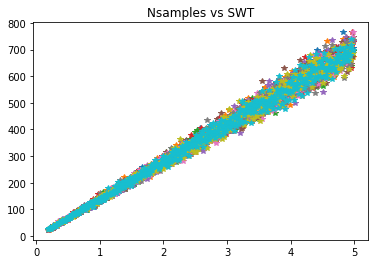

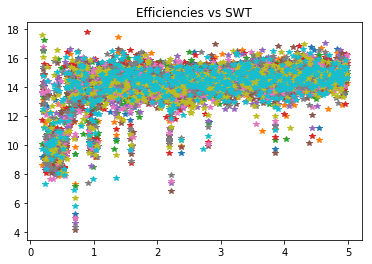

In [46]:
SUFFIX = ""
DOWNSAMPLE = 4 # TRYOUT
OUTPATH = "SIMSWT0"

path = OUTPATH
BASENAME = os.path.relpath(path) # USE FOLDER NAME AS ANALYSIS NAME

if DOWNSAMPLE > 1:
    print(f"[WARNING]: Downsampling by {DOWNSAMPLE}")
    SUFFIX = f"_DNSMPL{DOWNSAMPLE}"
    
# Simulation
sm = FSVSpectrumMaker.from_dict()
noise = make_ideal_thermal_noise(temperature=290, resistance=50)
sm.input = noise
sm.rbw = 100
sm.span = 1e5
sm.start_frequency = 0
sm.stop_frequency = 100e3
sm.padcoeff = 4 # PADDING!!
# currently can't enter number of points
sm.is_auto_swt = True

minswt = sm.swt
maxtime_s = 5 #s
Kmax = int(np.floor(maxtime_s/minswt))
Kmin = 10
increment = .5
SWTLIST = np.arange(Kmin, Kmax, increment)*minswt # measure at multiples of swt
MEASCOUNT = 10

def measuregen(sm, swts, meascount):
    for swt in swts:
        for measno in range(meascount):
            print(f"Simulating swt: {swt} s. Measno: {measno}")
            sm.swt = swt
            start = time.time()
            sm.generate()
            end = time.time()
            param = MeasurementParams.from_dict(dict(
                measno=measno,
                swt=swt,
                qswt=swt,
                points=len(sm.frequency),
                elapsed=end-start, # SIMULATION TIME
                rbw=sm.rbw,
                span=sm.span)
            )
            yield sm.frequency, sm.spectrum, param

simtuples = measuregen(sm, SWTLIST, MEASCOUNT)

# Analysis
experiment = Experiment.from_tuple_iterable(simtuples, downsampling=DOWNSAMPLE)

analysed = analyse(experiment)
flattnd = analysed.flatten()
flattnd.to_csv(f"{os.path.relpath(path)}{SUFFIX}.csv")

fignsamples,_ = analysed.plot('nsamples')
figeffs,_ = analysed.plot('efficiencies')

fignsamples.savefig(f'{BASENAME}_nsamples{SUFFIX}.png', dpi=300)
# fignsamples.savefig(f'{BASENAME}_nsamples{SUFFIX}.pdf')
figeffs.savefig(f'{BASENAME}_efficiencies{SUFFIX}.png', dpi=300)
# figeffs.savefig(f'{BASENAME}_efficiencies{SUFFIX}.pdf')

# One of the runs have less measurement number, I want to figure out which
# one
whichs = np.where([len(arr)<10 for arr in analysed.nsamples])[0]
whichswts = [analysed.swts[which] for which in whichs]
whichvals = [len(analysed.nsamples[which]) for which in whichs]
for whichswt, whichval in zip(whichswts, whichvals):
    print(f"Run with {whichswt} sweep time has {whichval} measurements!")

# plt.show()